## Predict Tm using embeddings from ProteinMPNN
- Then see if combining esm2 embeddings with proteinMPNN will further improve things

### First download structures for each protein

In [5]:
import json, time, os, sys, glob, re
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm, trange
tqdm.pandas()

# git clone https://github.com/dauparas/ProteinMPNN.git"
# add to path
base_dir = "/projects/bpms/jlaw/tools/ProteinMPNN"
sys.path.append(base_dir)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [153]:
# Setup Model
import warnings
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, StructureLoader, ProteinMPNN

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "v_48_010" #@param ["v_48_002", "v_48_010", "v_48_020", "v_48_030"]

# Standard deviation of Gaussian noise to add to backbone atoms
backbone_noise=0.0  

path_to_model_weights = f'{base_dir}/vanilla_model_weights'          
hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device) 
print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

Number of edges: 48
Training noise level: 0.1A
Model loaded


In [3]:
inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/")

### Extracting ProteinMPNN Embeddings

In [46]:
meltome_structures = {}
for pickle_file in glob.glob(f"{inputs_dir}/structures/*.p"):
    structures = pickle.load(open(pickle_file, 'rb'))
    print(f"{len(structures)} read from {pickle_file}")
    if 'meltome_processed.p' in pickle_file:
        structures = {os.path.basename(file_path).split('-')[1]: x 
                      for file_path, x in structures.items()}
    meltome_structures.update(structures)
print(len(meltome_structures))

3046 read from /projects/robustmicrob/jlaw/inputs/structures/UP000000589_10090_MOUSE_v4.p
1565 read from /projects/robustmicrob/jlaw/inputs/structures/UP000002311_559292_YEAST_v4.p
5218 read from /projects/robustmicrob/jlaw/inputs/structures/UP000005640_9606_HUMAN_v4.p
5786 read from /projects/robustmicrob/jlaw/inputs/structures/meltome_processed.p
963 read from /projects/robustmicrob/jlaw/inputs/structures/UP000000803_7227_DROME_v4.p
1985 read from /projects/robustmicrob/jlaw/inputs/structures/UP000001940_6239_CAEEL_v4.p
1478 read from /projects/robustmicrob/jlaw/inputs/structures/UP000000625_83333_ECOLI_v4.p
55 read from /projects/robustmicrob/jlaw/inputs/structures/UP000000437_7955_DANRE_v4.p
1569 read from /projects/robustmicrob/jlaw/inputs/structures/UP000006548_3702_ARATH_v4.p
21665


In [54]:
pdb_dict_list = []
for u_id, dict_list in meltome_structures.items():
    pdb_dict = dict_list[0]
    pdb_dict['uniprot_id'] = u_id
    pdb_dict['name'] = u_id
    pdb_dict_list.append(pdb_dict)

In [21]:
len(pdb_dict_list)

21665

In [22]:
set(key for pdb_dict in pdb_dict_list for key in pdb_dict.keys() if 'seq_chain' in key)

{'seq_chain_A'}

In [10]:
max_length = 5000
# number of tokens for one batch
# batch_size = 10000
# batch_size = 5000
batch_size = 5000

In [11]:
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))

In [12]:
def my_featurize(batch, device):
    homomer = False #@param {type:"boolean"}
    designed_chain = "A" #@param {type:"string"}
    fixed_chain = "" #@param {type:"string"}

    designed_chain_list = ["A"]
    fixed_chain_list = []
    chain_list = list(set(designed_chain_list + fixed_chain_list))

    chain_id_dict = {pdb_dict['name']: (designed_chain_list, fixed_chain_list) for pdb_dict in batch}
    tied_positions_dict = None

    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, \
    visible_list_list, masked_list_list, masked_chain_length_list_list, \
    chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, \
    tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, \
    bias_by_res_all, tied_beta = \
        protein_mpnn_utils.tied_featurize(
    batch, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, \
    tied_positions_dict, pssm_dict, bias_by_res_dict)
    
    return X, S, mask, lengths, chain_M, chain_M_pos, residue_idx, chain_encoding_all

In [23]:
# create the dataset objects
dataset = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)
loader = StructureLoader(dataset, batch_size=batch_size)
seq_ids = [b['uniprot_id'] for batch in loader for b in batch]
print(len(pdb_dict_list), len(seq_ids))

21665 21665


In [47]:
uniprot_to_seq = {pdb_dict['uniprot_id']: pdb_dict['seq'] 
                  for pdb_dict in pdb_dict_list}
seqs = [uniprot_to_seq[u_id] for u_id in seq_ids]

In [55]:
seq_to_uniprot = {pdb_dict['seq']: pdb_dict['uniprot_id'] 
                  for pdb_dict in pdb_dict_list}
seq_ids = [seq_to_uniprot[u_id] for u_id in seqs]

In [24]:
# Build the embeddings by taking the last layer before log_probs
representations = []
seqs = []
with torch.no_grad():
    for batch in tqdm(loader):
        start_batch = time.time()
        X, S, mask, lengths, chain_M, chain_M_pos, residue_idx, chain_encoding_all = my_featurize(batch, device)
        randn_1 = torch.randn(chain_M.shape, device=X.device)
        log_probs, h_V = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1, return_embedding=True)
        h_V = h_V.detach().to('cpu').numpy()
        
        for i in range(len(batch)):
            representations += [h_V[i, :len(batch[i]['seq'])].mean(0).astype(np.float16)]
            seqs += [(batch[i]['uniprot_id'],batch[i]['seq'])]

representations = np.vstack(representations)

  0%|          | 0/2046 [00:00<?, ?it/s]

In [58]:
# write the representations to file
out_file = f"{inputs_dir}/structures/embeddings/20230221_embeddings_{model_name}.npz"
print(f"Writing embeddings to {out_file}")
os.makedirs(os.path.dirname(out_file), exist_ok=True)
np.savez(out_file, representations)
with open(out_file.replace('.npz','.csv'), 'w') as out:
    out.write('\n'.join([f"{seq_to_uniprot[seq]},{seq}" for seq in seqs]) + '\n')

Writing embeddings to /projects/robustmicrob/jlaw/inputs/structures/embeddings/20230221_embeddings_v_48_010.npz


In [ ]:
# create the dataset objects
dataset2 = StructureDatasetPDB(pdb_dict_list[:10], truncate=None, max_length=max_length)
loader2 = StructureLoader(dataset2, batch_size=batch_size)
print(len(pdb_dict_list[:10]), len(seqs2))

10 9


In [ ]:
# Build the embeddings by taking the last layer before log_probs
representations2 = []
with torch.no_grad():
    for batch in tqdm(loader2):
        start_batch = time.time()
        X, S, mask, lengths, chain_M, chain_M_pos, residue_idx, chain_encoding_all = my_featurize(batch, device)
        randn_1 = torch.randn(chain_M.shape, device=X.device)
        log_probs, h_V = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1, return_embedding=True)
        h_V = h_V.detach().to('cpu').numpy()
        
        for i in range(len(batch)):
            representations2 += [h_V[i, :len(batch[i]['seq'])].mean(0).astype(np.float16)]
            seqs2 += [batch[i]['seq']]

representations2 = np.vstack(representations2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
seqs2[0]

'MSRSTRSKERRENDTDSEDNSSETSNQERRRCRQGPPRPPYPPLLPPVFPPPTPPPQVRRTRGLQDLGAMKSVCPGTSGFSSPNPSAASAAAQEVRSATDGNTSTTPPTSAKKRKLNSSSSSSNSSNEREDFDSTSSSSTPPQPRDSASPSTSSFCLGVPVATSSHVPIQKKLRFEDTLEFVGIDTKMAEESSSSSSSSSPTAATSQQQQQQQLKTKSILISSVASVHHANGLAKSSTAVSSFANSKPGSAKKLVIKNFKDKPKLPENYTDETWQKLKEAVEAIQNSTSIKYNLEELYQAVENLCSHKISANLYKQLRQICEDHIKAQIHQFREDSLDSVLFLKKIDRCWQNHCRQMIMIRSIFLFLDRTYVLQNSMLPSIWDMGLELFRAHIISDQKVQTKTIDGILLLIERERNGEAIDRSLLRSLLSMLSDLQIYQDSFEQQFLQETNRLYAAEGQKLMQEREVPEYLHHVNKRLEEEADRLITYLDQTTQKSLIASVEKQLLGEHLTAILQKGLNSLLDENRIQDLSLLYQLFSRVRGGVQVLLQQWIEYIKAFGSTIVINPEKDKTMVQELLDFKDKVDHIIDTCFLKNEKFINAMKEAFETFINKRPNKPAELIAKYVDSKLRAGNKEATDEELEKMLDKIMIIFRFIYGKDVFEAFYKKDLAKRLLVGKSASVDAEKSMLSKLKHECGAAFTSKLEGMFKDMELSKDIMIQFKQYMQNQNVPGNIELTVNILTMGYWPTYVPMEVHLPPEMVKLQEIFKTFYLGKHSGRKLQWQSTLGHCVLKAEFKEGKKELQVSLFQTMVLLMFNEGEEFSLEEIKHATGIEDGELRRTLQSLACGKARVLAKNPKGKDIEDGDKFICNDDFKHKLFRIKINQIQMKETVEEQASTTERVFQDRQYQIDAAIVRIMKMRKTLSHNLLVSEVYNQLKFPVKPADLKKRIESLIDRDYMERDKENPNQYNYIA'

In [ ]:
representations2[0]

array([ 6.8998e-04,  9.1614e-02,  1.6711e-01,  1.8372e-02,  4.5471e-02,
       -6.7177e-03,  2.0172e-02,  3.6774e-02, -3.5376e-01, -1.0223e-01,
        5.8777e-02,  2.8412e-02, -2.2125e-02, -2.2559e-01, -4.7607e-02,
       -4.3030e-02,  1.2903e-01,  1.2006e-01, -4.2816e-02, -1.9165e-01,
       -4.0967e-01,  7.6027e-03,  3.2104e-02, -4.6021e-02, -6.0806e-03,
        7.0190e-02,  1.5161e-01, -3.9215e-02, -3.9307e-02, -2.9419e-02,
       -5.3223e-02, -5.0163e-03, -6.7940e-03,  9.8694e-02, -2.3132e-02,
        1.3771e-03,  3.9886e-02, -7.6294e-02, -7.3242e-02, -1.0033e-02,
       -4.8035e-02, -1.1420e-01,  1.5857e-01, -4.5128e-03, -2.8442e-02,
        8.9783e-02,  9.8816e-02,  4.9515e-03,  3.1147e-03, -1.1896e-01,
       -7.8857e-02, -6.8604e-02,  6.4941e-02,  1.6028e-01, -1.8677e-02,
        1.5068e-02, -1.6711e-01,  4.1626e-02, -1.3000e-01, -4.9530e-02,
       -1.0162e-01,  6.1737e-02,  3.0664e-01,  2.1191e-01, -8.0261e-02,
       -4.9805e-02, -4.7241e-02, -1.2960e-03,  1.8143e-02, -5.25

In [109]:
protmpnn_embed[seq_idx[seqs2[0]]]

array([-0.04837  ,  0.0905   ,  0.08093  ,  0.003654 ,  0.02696  ,
       -0.005497 ,  0.01802  , -0.0525   , -0.39     , -0.06235  ,
        0.003477 , -0.0115   , -0.006016 , -0.0745   , -0.04755  ,
       -0.0463   ,  0.1361   , -0.04825  ,  0.0004542, -0.1658   ,
       -0.2576   ,  0.05072  ,  0.0411   , -0.033    , -0.006104 ,
       -0.02608  , -0.004765 , -0.008606 , -0.01202  , -0.03912  ,
        0.02258  , -0.00794  ,  0.013115 ,  0.04172  , -0.01683  ,
        0.001449 , -0.00503  ,  0.04916  , -0.0941   ,  0.01602  ,
       -0.0411   , -0.03226  ,  0.1548   ,  0.01109  , -0.0415   ,
       -0.03506  ,  0.006298 ,  0.00911  ,  0.00306  , -0.08936  ,
        0.09155  , -0.06088  , -0.015144 , -0.01247  ,  0.02469  ,
        0.1049   , -0.2025   ,  0.0735   , -0.1001   , -0.05853  ,
       -0.1985   , -0.00401  ,  0.1417   ,  0.02632  , -0.01086  ,
        0.02335  , -0.012634 , -0.003706 , -0.05927  , -0.03796  ,
        0.00713  , -0.02951  ,  0.0232   , -0.0944   ,  0.0257

In [32]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [120]:
protmpnn_embed, df_seq = read_embeddings(Path(inputs_dir, "structures/embeddings/20230221_embeddings_v_48_010.npz"),
                                         Path(inputs_dir, "structures/embeddings/20230221_embeddings_v_48_010.csv"))
protmpnn_seq = df_seq.sequence.values
# map from the sequence to the idx to access the correct row in the matrix
seq_idx = {seq: i for i, seq in enumerate(protmpnn_seq)}
protmpnn_embed.shape

len(embeddings) = 21665 read from /projects/robustmicrob/jlaw/inputs/structures/embeddings/20230221_embeddings_v_48_010.npz
len(sequences) = 21665 read from /projects/robustmicrob/jlaw/inputs/structures/embeddings/20230221_embeddings_v_48_010.csv


(21665, 128)

### Now try and predict tm for the meltome dataset

In [113]:
# try using the same train/test splits that flip used
df_split = pd.read_csv(Path(inputs_dir, "meltome/flip/github/splits/mixed_split.csv"))
print(len(df_split))
df_split.head(2)

27951


,sequence,target,set,validation
0,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...,37.962947,train,NaN
1,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...,54.425342,train,NaN


In [117]:
df_split_w_embed = df_split[df_split.sequence.isin(protmpnn_seq)]
print(len(df_split_w_embed))

24205


In [118]:
seqs = df_split_w_embed.sequence.unique()
len(seqs)

20210

In [121]:
df_train = df_split_w_embed[df_split_w_embed.set == "train"]
print(len(df_train), f"{len(df_train) / len(df_split_w_embed):0.2f}")

# X_train = embeddings[df_seq[df_seq.sequence.isin(train_seq)].index]
# y_train = df_seq[df_seq.sequence.isin(train_seq)].Tm
# X_test = embeddings[df_seq[df_seq.sequence.isin(test)].index]
# y_test = df_seq[df_seq.sequence.isin(test)].Tm
# some of the sequences are repeated, so get their embeddings by index
X_train = np.asarray([protmpnn_embed[seq_idx[seq]] for seq in df_train.sequence.values])
y_train = df_train.target.values

df_test = df_split_w_embed[df_split_w_embed.set == "test"]
print(len(df_test), f"{len(df_test) / len(df_split_w_embed):0.2f}")
X_test = np.asarray([protmpnn_embed[seq_idx[seq]] for seq in df_test.sequence.values])
y_test = df_test.target

21500 0.89
2705 0.11


In [122]:
X_train.shape

(21500, 128)

In [123]:
X_test.shape

(2705, 128)

### Build neural net on sequence embeddings

In [82]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [59]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [129]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, initial_layer_size=1280):
        super(NeuralNetwork, self).__init__()
        second_layer_size = initial_layer_size // 2
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, second_layer_size),
            nn.ReLU(),            
            nn.Linear(second_layer_size, second_layer_size),
            nn.ReLU(),
            nn.Linear(second_layer_size, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y, mask = batch

        y_pred = self(x).squeeze(1)
        # y_pred = y_pred[mask]
        # y2 = y[mask]
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, mask = batch
        y_pred = self(x).squeeze(1)
        loss = nn.functional.mse_loss(y_pred, y)        
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [75]:
def fit_model(X_train, y_train, y_mask, X_valid):
    pl.seed_everything(42)
    model = NeuralNetwork(initial_layer_size=X_train.shape[1])
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=20,
        check_val_every_n_epoch=5)

    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), 
                                                   torch.Tensor(y_train).to(device), 
                                                   torch.BoolTensor(y_mask))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model

In [124]:
head_model = fit_model(X_train, y_train, np.ones(len(y_train)), X_test)

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 329 K 
------------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [22]:
y_pred

array([41.291304  , 57.40688689, 48.70840559, ..., 51.3358366 ,
       48.4598702 , 45.55637478])

In [127]:
# y_pred = fit_predict(X_train, y_train, X_test).flatten()
# y_pred = model(torch.Tensor(X_test).to('cuda')[2].unsqueeze(1).detach().cpu()
y_pred = head_model(torch.Tensor(X_test)).detach().squeeze().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 5.9, mse = 62.8, rho = 0.49


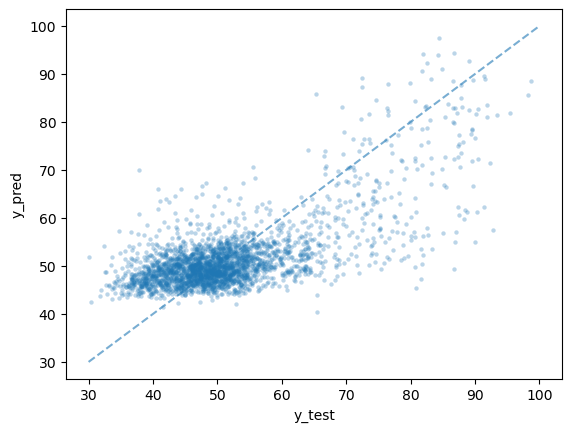

In [128]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([30,100], [30,100], '--', alpha=0.6)
plt.show()

### Now try combining protmpnn and esm

In [130]:
esm_embed, esm_seq = read_embeddings(Path(inputs_dir, "meltome/embeddings/20230206_embeddings_esm2_t33_650M_UR50D.npz"),
                                     Path(inputs_dir, "meltome/embeddings/20230125_embeddings_seqs.csv"))
esm_seq_idx = {seq: i for i, seq in enumerate(esm_seq.sequence)}
esm_embed.shape

len(embeddings) = 32563 read from /projects/robustmicrob/jlaw/inputs/meltome/embeddings/20230206_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 32563 read from /projects/robustmicrob/jlaw/inputs/meltome/embeddings/20230125_embeddings_seqs.csv


(32563, 1280)

In [131]:
seqs = set(protmpnn_seq) | set(esm_seq.sequence.values)
df_split_w_embed = df_split[df_split.sequence.isin(seqs)]
print(len(df_split_w_embed))

26082


In [132]:
seqs_w_embed = df_split_w_embed.sequence.unique()
len(seqs_w_embed)

21721

In [137]:
def combine_embeddings(seq):
    combined_embed = []
    for embeddings, s_idx in [(esm_embed, esm_seq_idx),
                              (protmpnn_embed, seq_idx)]:
        seq_embed = np.zeros(embeddings.shape[1])        
        if seq in s_idx:
            seq_embed = embeddings[s_idx[seq]]
        combined_embed += [seq_embed]
        
    combined_embed = np.hstack(combined_embed)
    return combined_embed

In [139]:
df_train = df_split_w_embed[df_split_w_embed.set == "train"]
print(len(df_train), f"{len(df_train) / len(df_split_w_embed):0.2f}")

# some of the sequences are repeated, so get their embeddings by index
X_train = np.asarray([combine_embeddings(seq) for seq in df_train.sequence.values])
y_train = df_train.target.values
print(X_train.shape, y_train.shape)

df_test = df_split_w_embed[df_split_w_embed.set == "test"]
print(len(df_test), f"{len(df_test) / len(df_split_w_embed):0.2f}")
X_test = np.asarray([combine_embeddings(seq) for seq in df_test.sequence.values])
y_test = df_test.target.values
print(X_test.shape, y_test.shape)

23185 0.89
(23185, 1408) (23185,)
2897 0.11
(2897, 1408) (2897,)


In [140]:
head_model = fit_model(X_train, y_train, np.ones(len(y_train)), X_test)

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 1.5 M 
------------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [141]:
# y_pred = fit_predict(X_train, y_train, X_test).flatten()
# y_pred = model(torch.Tensor(X_test).to('cuda')[2].unsqueeze(1).detach().cpu()
y_pred = head_model(torch.Tensor(X_test)).detach().squeeze().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = np.abs(y_pred - y_test).mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 4.7, mse = 38.3, rho = 0.66


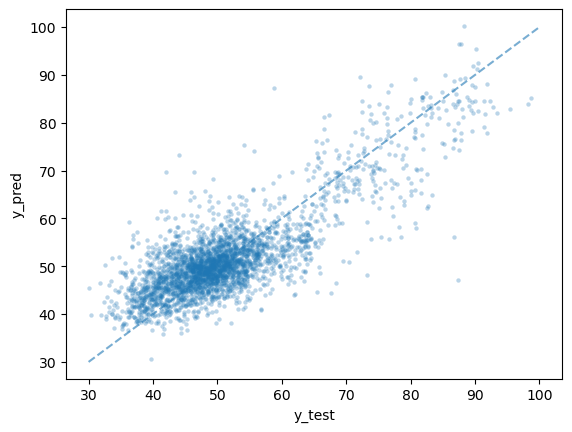

In [143]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([30,100], [30,100], '--', alpha=0.6)
plt.show()

### Try using attention on the proteinmpnn AA embeddings

In [169]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint


# copied from here: https://github.com/microsoft/protein-sequence-models/blob/main/sequence_models/convolutional.py
class MaskedConv1d(nn.Conv1d):
    """ A masked 1-dimensional convolution layer.
    Takes the same arguments as torch.nn.Conv1D, except that the padding is set automatically.
         Shape:
            Input: (N, L, in_channels)
            input_mask: (N, L, 1), optional
            Output: (N, L, out_channels)
    """

    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: int, stride: int=1, dilation: int=1, groups: int=1,
                 bias: bool=True):
        """
        :param in_channels: input channels
        :param out_channels: output channels
        :param kernel_size: the kernel width
        :param stride: filter shift
        :param dilation: dilation factor
        :param groups: perform depth-wise convolutions
        :param bias: adds learnable bias to output
        """
        padding = dilation * (kernel_size - 1) // 2
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation,
                                           groups=groups, bias=bias, padding=padding)

    def forward(self, x, input_mask=None):
        if input_mask is not None:
            x = x * input_mask
        return super().forward(x.transpose(1, 2)).transpose(1, 2)
    

# copied from here: https://github.com/microsoft/protein-sequence-models/blob/main/sequence_models/structure.py
class Attention1d(nn.Module):
    
    def __init__(self, in_dim):
        super().__init__()
        self.layer = MaskedConv1d(in_dim, 1, 1)

    def forward(self, x, input_mask=None):
        n, ell, _ = x.shape
        attn = self.layer(x)
        attn = attn.view(n, -1)
        if input_mask is not None:
            attn = attn.masked_fill_(~input_mask.view(n, -1).bool(), float('-inf'))
        attn = F.softmax(attn, dim=-1).view(n, -1, 1)
        out = (attn * x).sum(dim=1)
        return out
    
    
# copied from here: https://github.com/J-SNACKKB/FLIP/blob/main/baselines/models.py
class ESMAttention1d(pl.LightningModule):
    """Outputs of the ESM model with the attention1d"""
    def __init__(self, max_length, d_embedding): # [batch x sequence(751) x embedding (1280)] --> [batch x embedding] --> [batch x 1]
        super(ESMAttention1d, self).__init__()
        self.attention1d = Attention1d(in_dim=d_embedding) # ???
        self.linear = nn.Linear(d_embedding, d_embedding)
        self.relu = nn.ReLU()
        self.final = nn.Linear(d_embedding, 1)
    
    def forward(self, x):
        x = self.attention1d(x)
        x = self.relu(self.linear(x))
        x = self.final(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y, mask = batch

        y_pred = self(x).squeeze(1)
        # y_pred = y_pred[mask]
        # y2 = y[mask]
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [168]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, initial_layer_size=1280):
        super(NeuralNetwork, self).__init__()
        second_layer_size = initial_layer_size // 2
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, second_layer_size),
            nn.ReLU(),            
            nn.Linear(second_layer_size, second_layer_size),
            nn.ReLU(),
            nn.Linear(second_layer_size, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y, mask = batch

        y_pred = self(x).squeeze(1)
        # y_pred = y_pred[mask]
        # y2 = y[mask]
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, mask = batch
        y_pred = self(x).squeeze(1)
        loss = nn.functional.mse_loss(y_pred, y)        
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [224]:
def fit_model_att(X_train, y_train, y_mask, X_valid):
    pl.seed_everything(42)
    esm_model = ESMAttention1d(1500, X_train.shape[-1])
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=20,
        check_val_every_n_epoch=5)

    # train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), 
    train_dataset = torch.utils.data.TensorDataset(X_train.to(device), 
                                                   torch.Tensor(y_train).to(device), 
                                                   torch.BoolTensor(y_mask))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(esm_model, train_loader)
    
    return esm_model

In [161]:
max_seq_length = 1500

In [164]:
# Build the embeddings by taking the last layer before log_probs
dataset = StructureDatasetPDB(pdb_dict_list[:10], truncate=None, max_length=max_length)
loader = StructureLoader(dataset, batch_size=batch_size)

aa_embed = np.zeros([len(dataset), max_seq_length, 128])
seqs = []
with torch.no_grad():
    idx = 0
    for batch in tqdm(loader):
        start_batch = time.time()
        X, S, mask, lengths, chain_M, chain_M_pos, residue_idx, chain_encoding_all = my_featurize(batch, device)
        randn_1 = torch.randn(chain_M.shape, device=X.device)
        log_probs, h_V = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1, return_embedding=True)
        h_V = h_V.detach().to('cpu').numpy()
        print(h_V.shape)
        
        for j in range(len(batch)):
            # representations += [h_V[i, :len(batch[j]['seq'])].mean(0).astype(np.float16)]
            aa_embed[idx, :h_V.shape[1], :] = h_V[j]
            seqs += [(batch[j]['uniprot_id'],batch[j]['seq'])]
            idx += 1

# test_r = np.vstack(test_r)
aa_embed.shape

  0%|          | 0/2 [00:00<?, ?it/s]

(4, 999, 128)
(6, 736, 128)


(10, 1500, 128)

In [219]:
# These embeddings take up much more space
# protmpnn_aa_embed, df_seq = read_embeddings(Path(inputs_dir, "structures/embeddings/20230221_aa_embeddings_v_48_010.npz"),
#                                          Path(inputs_dir, "structures/embeddings/20230221_aa_embeddings_v_48_010.csv"))
protmpnn_aa_embed = torch.Tensor(protmpnn_aa_embed)
mask = protmpnn_aa_embed > 0
protmpnn_aa_embed = torch.masked.as_masked_tensor(protmpnn_aa_embed, mask)
protmpnn_aa_seq = df_seq.sequence.values
# map from the sequence to the idx to access the correct row in the matrix
seq_idx = {seq: i for i, seq in enumerate(protmpnn_aa_seq)}
protmpnn_aa_embed.shape

/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


torch.Size([21665, 1500, 128])

In [171]:
X_train.shape

(23185, 1408)

In [192]:
del X_train, X_test, protmpnn_aa_embed

In [186]:
df_split_w_embed2 = df_split_w_embed[df_split_w_embed.sequence.isin(seq_idx)]

In [222]:
df_train = df_split_w_embed2[df_split_w_embed2.set == "train"]
print(len(df_train), f"{len(df_train) / len(df_split_w_embed):0.2f}")

# some of the sequences are repeated, so get their embeddings by index
# X_train = np.asarray([protmpnn_aa_embed[seq_idx[seq]] for seq in df_train.sequence.values])
X_train = protmpnn_aa_embed[[seq_idx[seq] for seq in df_train.sequence.values]]
y_train = df_train.target.values

df_test = df_split_w_embed2[df_split_w_embed2.set == "test"]
print(len(df_test), f"{len(df_test) / len(df_split_w_embed):0.2f}")
# X_test = np.asarray([protmpnn_aa_embed[seq_idx[seq]] for seq in df_test.sequence.values])
X_test = protmpnn_aa_embed[[seq_idx[seq] for seq in df_test.sequence.values]]
y_test = df_test.target
print(X_train.shape)

21500 0.82
2705 0.10
torch.Size([21500, 1500, 128])


In [225]:
aa_model = fit_model_att(X_train, y_train, np.ones(len(y_train)), X_test)

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


OutOfMemoryError: CUDA out of memory. Tried to allocate 15.38 GiB (GPU 0; 31.75 GiB total capacity; 15.54 GiB already allocated; 13.46 GiB free; 15.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [190]:
y_pred = aa_model(torch.Tensor(X_test)).detach().squeeze().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 6.9, mse = 86.3, rho = 0.34


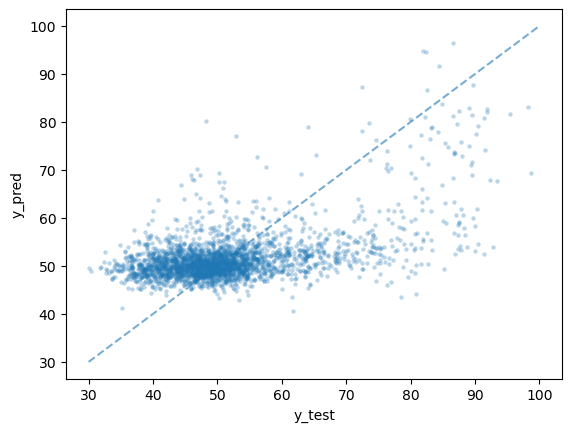

In [191]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([30,100], [30,100], '--', alpha=0.6)
plt.show()